In [1]:
import collections
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

import generate_dataset
from multiobject import generate_multiobject_dataset, iterate_video_dataset
from sprites import generate_dsprites, generate_binary_mnist, generate_simiansprites
from utils import get_date_str, show_img_grid

In [2]:
DELTA_T = 0.015
DISTANCE_TO_SCREEN = 106
FPS = 60
HOLD_DEGREES = 2
SCALE_MOVIE = 1
SCREEN_DIMS = (100, 62)
SCREEN_RES = (1920, 1080)
SCALED_VIDEO_RES = (SCREEN_RES[0], SCREEN_RES[1])
SPRITE_RES = (280, 280)
VIDEO_SECONDS = 4.5
VIDEO_RES = SCREEN_RES
VIDEO_THRESHOLDS = [
    [(SCREEN_RES[0] - SCALED_VIDEO_RES[0]) / 2, (SCREEN_RES[1] - SCALED_VIDEO_RES[1]) / 2],
    [(SCREEN_RES[0] + SCALED_VIDEO_RES[0]) / 2, (SCREEN_RES[1] + SCALED_VIDEO_RES[1]) / 2]
]

In [3]:
SCREEN_HALFWIDTH_DEGREES = np.degrees(np.arctan(SCREEN_DIMS[0] / 2 / DISTANCE_TO_SCREEN))
SCREEN_HALFHEIGHT_DEGREES = np.degrees(np.arctan(SCREEN_DIMS[1] / 2 / DISTANCE_TO_SCREEN))

In [4]:
def xdegrees_to_coords(theta):
    return theta / SCREEN_HALFWIDTH_DEGREES

def ydegrees_to_coords(theta):
    return theta / SCREEN_HALFHEIGHT_DEGREES

def visdeg_to_normalized_coords(xys):
    xs, ys = xdegrees_to_coords(xys[:, 0]), ydegrees_to_coords(xys[:, 1])
    return np.stack((xs, ys), axis=-1)

def rf_to_normalized_coords(rf):
    (x, y, rx, ry, theta) = rf
    x, rx = xdegrees_to_coords(x), xdegrees_to_coords(rx + HOLD_DEGREES)
    y, ry = ydegrees_to_coords(y), ydegrees_to_coords(ry + HOLD_DEGREES)
    return (x, y, rx, ry, theta)

In [5]:
VIDEOS_PER_SPRITE = 4
TIMESTEPS = VIDEO_SECONDS * FPS

In [6]:
sprites, attrs = generate_simiansprites(SPRITE_RES[0])

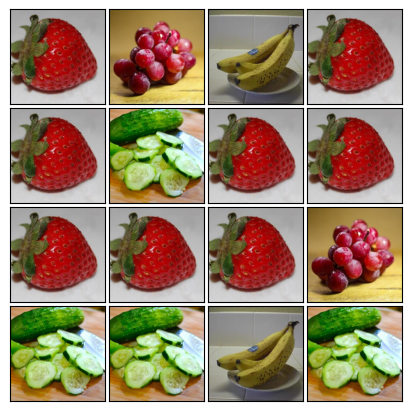

In [7]:
# Show sprites
show_img_grid(4, sprites, random_selection=True)

In [8]:
ch = sprites[0].shape[-1]
img_shape = (*SCREEN_RES, ch)

In [9]:
# June 25, 2024: the following are RFs taken from the recording sub-C31o_ses-230825.nwb in Cajal on August 25, 2023.
# The first one is Channel 51 on Probe B (MT, MST)
# The second one is Channel 83 on Probe C (V4, TEO).
# See Bastos Lab recording sheet: https://docs.google.com/spreadsheets/d/1FSPJK3k2w1mdn-Efde5DYrnIINQTsq84deYzr3WZR20/edit

MTMST_RF = (4.40469824640952, 1.57518412000701, 4.30410704691135, 3.98459138995464, 42.8616194233111)
V4TEO_RF = (1.28070829545476, -5.16197456514128, 3.96030672288700, 6.60645207866818, 77.7192801971439)

In [10]:
def start_points(rf, num_videos=4):
    theta = np.random.uniform(0, 2 * np.pi)
    thetas = np.arange(num_videos) * (2 * np.pi / num_videos) + theta
    distance = max(rf[2:4]) + HOLD_DEGREES + 3
    rx, ry = rf[2] + HOLD_DEGREES, rf[3] + HOLD_DEGREES
    perimeter_dirs = np.stack((rx * np.cos(thetas - np.deg2rad(rf[4])), ry * np.sin(thetas - np.deg2rad(rf[4]))), axis=-1)
    perimeter_dirs = perimeter_dirs / np.linalg.norm(perimeter_dirs, axis=-1, keepdims=True)
    return rf[:2] + perimeter_dirs * distance

In [11]:
def start_velocities(rf, sources):
    v0 = rf[:2] - sources
    v0 /= np.linalg.norm(v0)
    return v0 * 2 * max(rf[2:4]) / 1.5

In [12]:
def rf_video_parameters(rf):
    sources = start_points(rf, VIDEOS_PER_SPRITE)
    velocities = start_velocities(rf, sources)
    parameters = {
        "n": VIDEOS_PER_SPRITE,
        "sources": visdeg_to_normalized_coords(sources),
        "velocities": visdeg_to_normalized_coords(velocities),
    }
    return {k: parameters for k in attrs['labels']}

In [13]:
PARAMETERS = rf_video_parameters(MTMST_RF)

In [14]:
generator = iterate_video_dataset(img_shape, sprites, attrs, PARAMETERS, VIDEO_SECONDS,
                                  allow_overlap=True, rf=rf_to_normalized_coords(MTMST_RF))

In [15]:
GENERATED_PATH = 'generated/simiansprites/mtmst/full/'

In [16]:
if not os.path.exists(GENERATED_PATH):
    os.makedirs(GENERATED_PATH)

In [ ]:
for v, (video, _, labels) in generator:
    label = labels['labels']
    video_fname = GENERATED_PATH + label + '_' + str(v)
    video.write(video_fname)

num sprites: 4


  6%|█████████████████████▋                                                                                                                                                                                                                                                                                                                                    | 1/16 [00:49<12:16, 49.08s/it]

In [ ]:
PARAMETERS = rf_video_parameters(V4TEO_RF)

In [ ]:
generator = iterate_video_dataset(img_shape, sprites, attrs, PARAMETERS, VIDEO_SECONDS,
                                  allow_overlap=True, rf=rf_to_normalized_coords(V4TEO_RF))

In [ ]:
GENERATED_PATH = 'generated/simiansprites/v4teo/full/'

In [ ]:
if not os.path.exists(GENERATED_PATH):
    os.makedirs(GENERATED_PATH)

In [ ]:
fruit_types = collections.Counter()

In [ ]:
for v, (video, _, labels) in generator:
    label = labels['labels']
    video_fname = GENERATED_PATH + label + '_' + str(v)
    video.write(video_fname)